这个方法完全仿照课上PPT的做法。

## 导入数据

In [1]:
pip install -U d2l

     |████████████████████████████████| 77 kB 618 kB/s 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

train_data = pd.read_csv("../input/california-house-prices/train.csv")
test_data = pd.read_csv("../input/california-house-prices/test.csv")

In [3]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


其中*trian_data*比*test_data*多了一列，这一列就是我们要预测的房价。

In [4]:
[i for i in train_data.columns if i not in test_data.columns]

['Sold Price']

从上面可以看出，我们要预测的房价列名为```Sold Price```

## 数据预处理

### 特征选择

因为kaggle上内存有限，需要选择好哪些特征再进行下一步操作，以免超限。

为了让训练集和测试集一起完成数据预处理，还需要```cancat```。

我们先需要看一下train_data和test_data有哪些特征：

In [5]:
train_data.columns

Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School', 'Middle School Score', 'Middle School Distance',
       'High School', 'High School Score', 'High School Distance', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Tax assessed value',
       'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [6]:
test_data.columns

Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

train_data中```Sold Price```需要剔除，因为是标签。
train_data和test_data中的```Id```需要剔除，因为和结果无关。

除此之外，因为都是加州的房子，需要剔除```State```;```Summary```是文本数据，分析有限就直接剔除，同理```Address```：每个房子的地址都不同，如果进行独热编码负担太大，分析也有限，所以也剔除。

In [7]:
all_features = pd.concat((train_data.iloc[:, 4:-1], test_data.iloc[:, 3:-1]))

In [8]:
all_features.shape

(79065, 36)

### 处理缺失数据

先看一下有哪些列有缺失值：

In [9]:
missing_values_count = all_features.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count.loc[missing_values_count>0]

Year built                      1942
Heating                        11513
Cooling                        15109
Parking                         1676
Lot                            22989
Bedrooms                        4598
Bathrooms                       5410
Full bathrooms                 12928
Total interior livable area     3878
Total spaces                    1667
Garage spaces                   1667
Region                             2
Elementary School               8493
Elementary School Score         8735
Elementary School Distance      8493
Middle School                  28277
Middle School Score            28279
Middle School Distance         28277
High School                     7174
High School Score               7784
High School Distance            7175
Flooring                       21927
Heating features               12548
Cooling features               16633
Appliances included            23349
Laundry features               19982
Parking features                6628
T

所以数据集中缺失值占数据总数的......?

In [10]:
total_cells = np.product(all_features.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

13.693198985363662


In [11]:
all_features = all_features.fillna(method='bfill', axis=0).fillna(0)

来验证一下，NA是否都去除了：

In [12]:
missing_values_count = all_features.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count.loc[missing_values_count>0]

Series([], dtype: int64)

### 处理日期数据

In [13]:
all_features.columns

Index(['Type', 'Year built', 'Heating', 'Cooling', 'Parking', 'Lot',
       'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip'],
      dtype='object')

In [14]:
print(all_features['Listed On'].head())
print(all_features['Last Sold On'].head())

0    2019-10-24
1    2019-10-16
2    2019-08-25
3    2019-10-24
4    2019-06-07
Name: Listed On, dtype: object
0    2019-08-30
1    2019-08-30
2    2016-08-30
3    2016-08-30
4    2016-06-27
Name: Last Sold On, dtype: object


In [15]:
all_features['Listed On'] = pd.to_datetime(all_features['Listed On'], format="%Y-%m-%d")

In [16]:
all_features['Last Sold On'] = pd.to_datetime(all_features['Last Sold On'], format="%Y-%m-%d")

验证一下dtype：

In [17]:
print(all_features['Listed On'].head())
print(all_features['Last Sold On'].head())

0   2019-10-24
1   2019-10-16
2   2019-08-25
3   2019-10-24
4   2019-06-07
Name: Listed On, dtype: datetime64[ns]
0   2019-08-30
1   2019-08-30
2   2016-08-30
3   2016-08-30
4   2016-06-27
Name: Last Sold On, dtype: datetime64[ns]


### 标准化

看一下现在all_features中的数据有哪些类型：

In [18]:
all_features.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('<M8[ns]'), dtype('int64')],
      dtype=object)

In [19]:
numeric_features = all_features.dtypes[all_features.dtypes == 'float64'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

###  独热编码

查看一下all_features中类型为object的特征有哪些：

In [20]:
all_features.dtypes[all_features.dtypes=='object']

Type                   object
Heating                object
Cooling                object
Parking                object
Bedrooms               object
Region                 object
Elementary School      object
Middle School          object
High School            object
Flooring               object
Heating features       object
Cooling features       object
Appliances included    object
Laundry features       object
Parking features       object
City                   object
dtype: object

为了提高独热编码时的质量，我们看一下这些object类型中是否存在数据不一致的情况：

In [21]:
print(len(all_features['Type'].unique()))
print(len(all_features['Heating'].unique()))
print(len(all_features['Cooling'].unique()))
print(len(all_features['Parking'].unique()))
print(len(all_features['Bedrooms'].unique()))
print(len(all_features['Region'].unique()))
print(len(all_features['Elementary School'].unique()))
print(len(all_features['Middle School'].unique()))
print(len(all_features['High School'].unique()))
print(len(all_features['Flooring'].unique()))
print(len(all_features['Heating features'].unique()))
print(len(all_features['Cooling features'].unique()))
print(len(all_features['Appliances included'].unique()))
print(len(all_features['Laundry features'].unique()))
print(len(all_features['Parking features'].unique()))
print(len(all_features['City'].unique()))

174
2659
910
9912
277
1258
3567
809
921
1739
1762
595
11290
3030
9694
1122


从上面各个长度可以看出，特征包含的类别数太多，我们来看一下是什么情况：

In [22]:
all_features['Appliances included']

0        Dishwasher, Dryer, Garbage disposal, Microwave...
1                                               Dishwasher
2                                               Dishwasher
3                                               Dishwasher
4                                             Range / Oven
                               ...                        
31621    Dishwasher, Disposal, Dryer, Microwave, Oven, ...
31622    Dishwasher, Electric Oven, Disposal, Gas Water...
31623                      Dishwasher, Disposal, Microwave
31624                      Dishwasher, Disposal, Microwave
31625                                                    0
Name: Appliances included, Length: 79065, dtype: object

除了```Appliances included```以外，其他数量很大的类别也都是用逗号分隔的多类别文本数据。因为现在我的水平有限，不太知道这种数据怎么编码，所以决定把它们都剔除掉：

In [23]:
features = list(numeric_features)
features.append('Type')   # 加上类别数相对较少的Type
print(features)

['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Type']


In [24]:
all_features = all_features[features]

In [25]:
all_features.shape

(79065, 18)

进行编码：

In [26]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(79065, 192)

### 转为张量

In [27]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1,1), dtype=torch.float32)

## 训练

In [28]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,256), nn.ReLU(), nn.Linear(256,1))  
    #net = nn.Sequential(nn.Linear(in_features, 1))
    return net

### 选取loss函数：

因为不同区域的房价绝对数值相差很大，我们更关心相对误差：$\frac{y - \hat{y}}{y}$，所以我们定义loss为：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [29]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

### 训练函数

In [30]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []   # train_loss和test_loss
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法，对初始学习率没有那么敏感
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### k折交叉验证

In [31]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [32]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### 模型选择

fold 1, train log rmse 0.467627, valid log rmse 0.438364
fold 2, train log rmse 0.460689, valid log rmse 0.443255
fold 3, train log rmse 0.463760, valid log rmse 0.449689
fold 4, train log rmse 0.296666, valid log rmse 0.312078
fold 5, train log rmse 0.450245, valid log rmse 0.541860
5-折验证: 平均训练log rmse: 0.427798, 平均验证log rmse: 0.437049


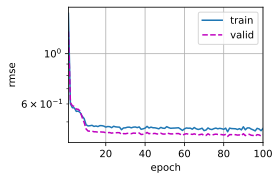

In [33]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0.1, 64    # 调参数
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

在模型选择的过程中发现，有的参数会使loss随着epoch增加波动过大，而不是稳定下降。这种情况很可能是因为batch_size不够大，模型不稳定，可以增大batch_size来缓解。

## 预测

In [34]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.441940


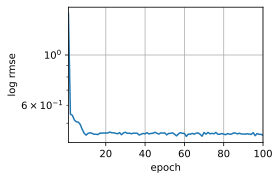

In [35]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)